In [125]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re
from spacy.matcher import Matcher
from spacy.util import filter_spans
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from gensim.models import Word2Vec ,KeyedVectors
import numpy as np


In [197]:
df = pd.read_csv('filtered_data.csv', sep='|')

In [198]:
df

,Unnamed: 0,category,headline,authors,link,short_description,date,Text,Section,Cleaned Text,Word Tokens,Filtered Tokens
0,0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,CRIME,there be 2 mass shootings in texas last week b...,"['there', 'be', '2', 'mass', 'shootings', 'in'...","['mass', 'shootings', 'texas', 'last', 'week',..."
1,1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,ENTERTAINMENT,will smith joins diplo and nicky jam for the 2...,"['will', 'smith', 'joins', 'diplo', 'and', 'ni...","['smith', 'joins', 'diplo', 'nicky', 'jam', 'w..."
2,2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,Hugh Grant Marries For The First Time At Age 5...,ENTERTAINMENT,hugh grant marrie for the first time at age 57...,"['hugh', 'grant', 'marrie', 'for', 'the', 'fir...","['hugh', 'grant', 'marrie', 'first', 'time', '..."
3,3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,ENTERTAINMENT,jim carrey blasts castrato adam schiff and dem...,"['jim', 'carrey', 'blasts', 'castrato', 'adam'...","['jim', 'carrey', 'blasts', 'castrato', 'adam'..."
4,4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,ENTERTAINMENT,julianna margulies use donald trump poop bag t...,"['julianna', 'margulies', 'use', 'donald', 'tr...","['julianna', 'margulies', 'use', 'donald', 'tr..."
...,...,...,...,...,...,...,...,...,...,...,...,...
200848,200848,TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,"Reuters, Reuters",https://www.huffingtonpost.com/entry/rim-ceo-t...,Verizon Wireless and AT&T are already promotin...,2012-01-28,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,SCIENCE & TECHNOLOGY,rim ceo thorsten hein significant plan for bla...,"['rim', 'ceo', 'thorsten', 'hein', 'significan...","['rim', 'ceo', 'thorsten', 'hein', 'significan..."
200849,200849,SPORTS,Maria Sharapova Stunned By Victoria Azarenka I...,NaN,https://www.huffingtonpost.com/entry/maria-sha...,"Afterward, Azarenka, more effusive with the pr...",2012-01-28,Maria Sharapova Stunned By Victoria Azarenka I...,SPORTS,maria sharapova stun by victoria azarenka in a...,"['maria', 'sharapova', 'stun', 'by', 'victoria...","['maria', 'sharapova', 'stun', 'victoria', 'az..."
200850,200850,SPORTS,"Giants Over Patriots, Jets Over Colts Among M...",NaN,https://www.huffingtonpost.com/entry/super-bow...,"Leading up to Super Bowl XLVI, the most talked...",2012-01-28,"Giants Over Patriots, Jets Over Colts Among M...",SPORTS,giant over patriots jet over colt among most...,"['giant', 'over', 'patriots', 'jet', 'over', '...","['giant', 'patriots', 'jet', 'colt', 'among', ..."
200851,200851,SPORTS,Aldon Smith Arrested: 49ers Linebacker Busted ...,NaN,https://www.huffingtonpost.com/entry/aldon-smi...,CORRECTION: An earlier version of this story i...,2012-01-28,Aldon Smith Arrested: 49ers Linebacker Busted ...,SPORTS,aldon smith arrested 49er linebacker bust for ...,"['aldon', 'smith', 'arrested', '49er', 'lineba...","['aldon', 'smith', 'arrested', '49er', 'lineba..."


In [243]:
stopwords = nltk.corpus.stopwords.words('english')

In [244]:
def get_tokens(text):
    tokens = nltk.word_tokenize(text)
    return tokens

In [245]:
def get_filtered_tokens(tokens):
    tokens_filtered = [t for t in tokens if t not in stopwords and t.isdigit() == False]
    return tokens_filtered
    

In [246]:
df['Word Tokens'] = df['Cleaned Text'].apply(get_tokens)

In [247]:
df['Filtered Tokens'] = df['Word Tokens'].apply(get_filtered_tokens)

### Plot Classification Report

In [223]:
def plot_classification_report(cr, title='Classification report ', with_avg_total=False, cmap=plt.cm.Blues):

    lines = cr.split('\n')

    classes = []
    plotMat = []
    for line in lines[2 : (len(lines) - 3)]:
        t = line.split()
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        plotMat.append(v)

    if with_avg_total:
        aveTotal = lines[len(lines) - 1].split()
        classes.append('avg/total')
        vAveTotal = [float(x) for x in t[1:len(aveTotal) - 1]]
        plotMat.append(vAveTotal)

    plt.figure(figsize=(10,10))
    plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
    plt.title(title, pad=10, fontweight="bold", fontsize=14)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('Classes', fontsize=11, fontweight="bold")
    plt.xlabel('Measures', fontsize=11, fontweight="bold")

-------------------

## Data Preparation for Models

### For Models with Count Vectorizer and Tf-idf Vectorizer 

In [200]:
X = df['Cleaned Text']
y = df['Section']

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

### For Models with Word2Vec

In [248]:
filtered_docs = []


for i in range(len(df)):
    filtered_docs.append(df['Filtered Tokens'][i])

In [251]:
filtered_docs[3]

['jim',
 'carrey',
 'blasts',
 'castrato',
 'adam',
 'schiff',
 'democrats',
 'new',
 'artwork',
 'actor',
 'give',
 'dems',
 'asskicking',
 'fight',
 'hard',
 'enough',
 'donald',
 'trump']

In [253]:
X_w2v = df['Filtered Tokens']
y_w2v = df['Section']

#### Word2Vec model and generating Training and Test data

In [254]:
model = Word2Vec(filtered_docs,  vector_size=50, sg=1, min_count=1)

In [255]:
model.wv['donald']

array([-0.53394127,  0.4092823 ,  0.20542106,  0.12314691,  0.0400571 ,
        0.14934649,  0.7597677 ,  1.1706312 ,  0.15661694, -0.20925961,
       -0.39329806,  0.29682207,  0.33212584, -1.3014543 , -0.3013388 ,
       -0.42221576,  0.6582692 , -1.0668337 , -0.625039  , -0.11188999,
       -0.4604525 , -0.3742587 ,  0.9964708 ,  0.42706373,  0.67502695,
        0.40767655, -0.21898991,  0.41697812,  0.01467493,  0.98232496,
        0.66453266, -0.17325073, -0.5573148 , -0.49842843,  0.2028749 ,
        0.39174992, -0.5052022 , -0.5173582 , -0.290223  , -0.3571007 ,
        0.03556153, -0.13190883,  0.8968706 ,  0.30303952,  0.7257445 ,
        0.18239409,  0.13886876, -0.65200365, -0.67641157, -0.03024454],
      dtype=float32)

In [256]:
model.save('word2vec_Model.bin')

In [257]:
w_vectors = KeyedVectors.load('word2vec_Model.bin')

In [258]:
X_wv_vector = []
for row in X_w2v:
    model_vector = (np.mean([w_vectors.wv[token] for token in row], axis=0)).tolist()
    if (type(model_vector) is list):
        X_wv_vector.append(model_vector)
    else:
        newList = [0]*50
        X_wv_vector.append(newList)
    

/usr/local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [259]:
len(X_wv_vector)

200853

In [260]:
X_w2v_train, X_w2v_test, y_w2v_train, y_w2v_test = train_test_split(np.array(X_wv_vector), np.array(y_w2v), test_size=0.25, random_state=12)


----------

## Linear SVC

### Count Vectorizer

#### Without class weights (Imbalanced data)

In [201]:
clf_cvec_lsvc = Pipeline([('cvec', CountVectorizer()),('clf', LinearSVC())])

# Feed the training data through the pipeline
clf_cvec_lsvc.fit(X_train, y_train)

/usr/local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Pipeline(steps=[('cvec', CountVectorizer()), ('clf', LinearSVC())])

In [202]:
predictions = clf_cvec_lsvc.predict(X_test)

print(metrics.classification_report(y_test,predictions))

cvec_lsvc_acc = metrics.accuracy_score(y_test,predictions)
print("Accuracy: " + str(cvec_lsvc_acc))

                      precision    recall  f1-score   support

      ARTS & CULTURE       0.50      0.40      0.44       992
               CRIME       0.52      0.46      0.49       856
           EDUCATION       0.39      0.38      0.39       550
         EMPOWERMENT       0.30      0.27      0.29      1213
       ENTERTAINMENT       0.69      0.73      0.71      9870
              FAMILY       0.70      0.70      0.70      4984
             FASHION       0.77      0.75      0.76      2982
             FINANCE       0.50      0.46      0.48      1951
             HYGIENE       0.58      0.55      0.57      2050
              IMPACT       0.28      0.26      0.27       865
               MEDIA       0.38      0.35      0.36      1717
            POLITICS       0.72      0.77      0.74      8061
            RELIGION       0.44      0.40      0.42       601
SCIENCE & TECHNOLOGY       0.49      0.43      0.46      1073
              SPORTS       0.68      0.65      0.66      1180
       

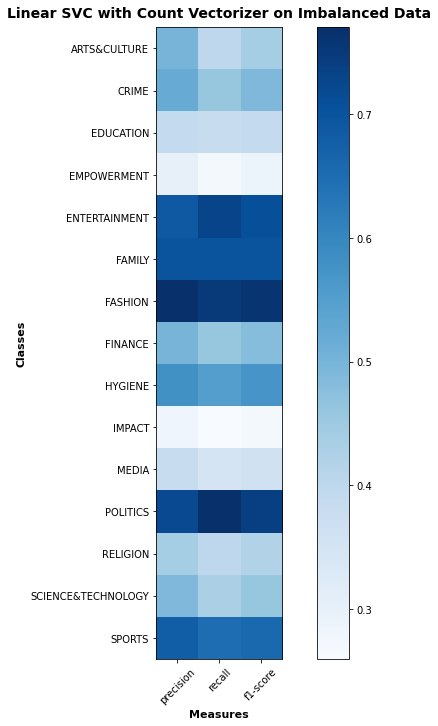

In [224]:
cvec_lsvc_ClassificationReport = """             precision    recall  f1-score   support

        ARTS&CULTURE       0.50      0.40      0.44       992
               CRIME       0.52      0.46      0.49       856
           EDUCATION       0.39      0.38      0.39       550
         EMPOWERMENT       0.30      0.27      0.29      1213
       ENTERTAINMENT       0.69      0.73      0.71      9870
              FAMILY       0.70      0.70      0.70      4984
             FASHION       0.77      0.75      0.76      2982
             FINANCE       0.50      0.46      0.48      1951
             HYGIENE       0.58      0.55      0.57      2050
              IMPACT       0.28      0.26      0.27       865
               MEDIA       0.38      0.35      0.36      1717
            POLITICS       0.72      0.77      0.74      8061
            RELIGION       0.44      0.40      0.42       601
  SCIENCE&TECHNOLOGY       0.49      0.43      0.46      1073
              SPORTS       0.68      0.65      0.66      1180
              VOICES       0.58      0.54      0.56      2981
            WELLNESS       0.69      0.72      0.70      6175
          WORLD NEWS       0.64      0.61      0.62      2113"""


cvec_lsvc_crplot = plot_classification_report(cvec_lsvc_ClassificationReport, title="Linear SVC with Count Vectorizer on Imbalanced Data")
cvec_lsvc_crplot

#### Using balanced class weights (Balanced Data)

In [217]:
clf_cvec_lsvc_cw = Pipeline([('cvec', CountVectorizer()),('clf', LinearSVC(class_weight='balanced'))])

# Feed the training data through the pipeline
clf_cvec_lsvc_cw.fit(X_train, y_train)

/usr/local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Pipeline(steps=[('cvec', CountVectorizer()),
                ('clf', LinearSVC(class_weight='balanced'))])

In [219]:
predictions = clf_cvec_lsvc_cw.predict(X_test)
print(metrics.classification_report(y_test,predictions))
cvec_lsvc_cw_acc = metrics.accuracy_score(y_test,predictions)
print("Accuracy: " + str(cvec_lsvc_cw_acc))

                      precision    recall  f1-score   support

      ARTS & CULTURE       0.43      0.42      0.42       992
               CRIME       0.47      0.50      0.48       856
           EDUCATION       0.32      0.40      0.36       550
         EMPOWERMENT       0.25      0.33      0.28      1213
       ENTERTAINMENT       0.74      0.66      0.70      9870
              FAMILY       0.71      0.70      0.70      4984
             FASHION       0.75      0.76      0.76      2982
             FINANCE       0.46      0.48      0.47      1951
             HYGIENE       0.55      0.58      0.56      2050
              IMPACT       0.23      0.29      0.25       865
               MEDIA       0.34      0.39      0.36      1717
            POLITICS       0.76      0.72      0.74      8061
            RELIGION       0.37      0.46      0.41       601
SCIENCE & TECHNOLOGY       0.41      0.46      0.43      1073
              SPORTS       0.63      0.68      0.65      1180
       

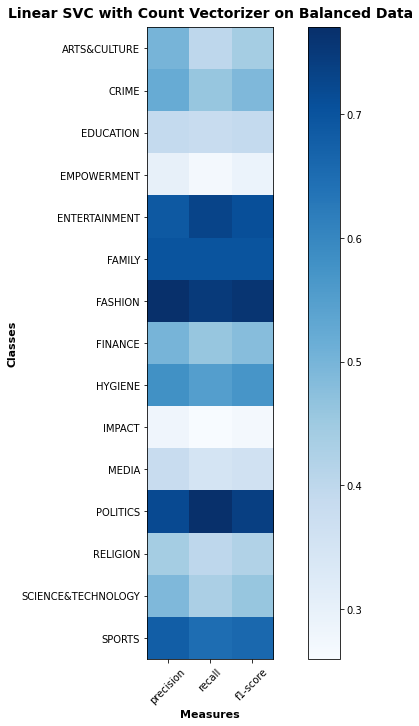

In [226]:
cvec_lsvc_cw_ClassificationReport = """             precision    recall  f1-score   support

        ARTS&CULTURE       0.50      0.40      0.44       992
               CRIME       0.52      0.46      0.49       856
           EDUCATION       0.39      0.38      0.39       550
         EMPOWERMENT       0.30      0.27      0.29      1213
       ENTERTAINMENT       0.69      0.73      0.71      9870
              FAMILY       0.70      0.70      0.70      4984
             FASHION       0.77      0.75      0.76      2982
             FINANCE       0.50      0.46      0.48      1951
             HYGIENE       0.58      0.55      0.57      2050
              IMPACT       0.28      0.26      0.27       865
               MEDIA       0.38      0.35      0.36      1717
            POLITICS       0.72      0.77      0.74      8061
            RELIGION       0.44      0.40      0.42       601
  SCIENCE&TECHNOLOGY       0.49      0.43      0.46      1073
              SPORTS       0.68      0.65      0.66      1180
              VOICES       0.58      0.54      0.56      2981
            WELLNESS       0.69      0.72      0.70      6175
          WORLD NEWS       0.64      0.61      0.62      2113"""


cvec_lsvc_cw_crplot = plot_classification_report(cvec_lsvc_cw_ClassificationReport, title="Linear SVC with Count Vectorizer on Balanced Data")
cvec_lsvc_cw_crplot


### Tf-idf Vectorizer

#### Imbalanced Data

In [229]:
clf_tfidf_lsvc = Pipeline([('tfidf', TfidfVectorizer()), ('clf', LinearSVC())])

# Feed the training data through the pipeline
clf_tfidf_lsvc.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LinearSVC())])

In [230]:
predictions = clf_tfidf_lsvc.predict(X_test)

print(metrics.classification_report(y_test,predictions))

tfidf_lsvc_acc = metrics.accuracy_score(y_test,predictions)
print("Accuracy: " + str(tfidf_lsvc_acc))

                      precision    recall  f1-score   support

      ARTS & CULTURE       0.61      0.44      0.51       992
               CRIME       0.62      0.52      0.56       856
           EDUCATION       0.55      0.43      0.48       550
         EMPOWERMENT       0.44      0.26      0.32      1213
       ENTERTAINMENT       0.70      0.80      0.75      9870
              FAMILY       0.74      0.77      0.75      4984
             FASHION       0.80      0.80      0.80      2982
             FINANCE       0.61      0.51      0.56      1951
             HYGIENE       0.65      0.61      0.63      2050
              IMPACT       0.45      0.27      0.34       865
               MEDIA       0.50      0.36      0.42      1717
            POLITICS       0.74      0.81      0.77      8061
            RELIGION       0.58      0.43      0.49       601
SCIENCE & TECHNOLOGY       0.61      0.46      0.52      1073
              SPORTS       0.73      0.72      0.72      1180
       

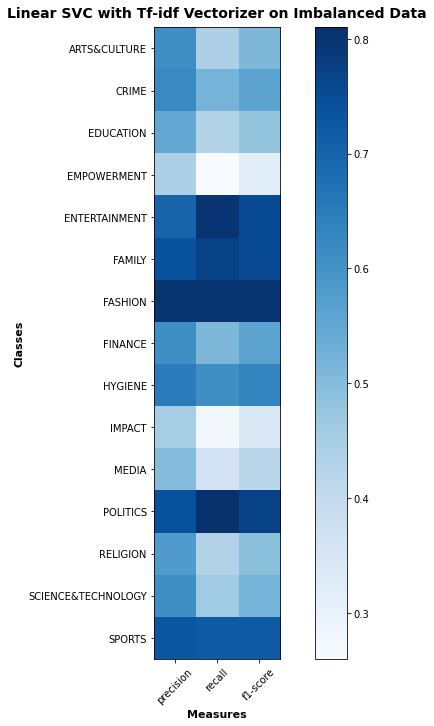

In [232]:
tfidf_lsvc_ClassificationReport = """             precision    recall  f1-score   support

        ARTS&CULTURE       0.61      0.44      0.51       992
               CRIME       0.62      0.52      0.56       856
           EDUCATION       0.55      0.43      0.48       550
         EMPOWERMENT       0.44      0.26      0.32      1213
       ENTERTAINMENT       0.70      0.80      0.75      9870
              FAMILY       0.74      0.77      0.75      4984
             FASHION       0.80      0.80      0.80      2982
             FINANCE       0.61      0.51      0.56      1951
             HYGIENE       0.65      0.61      0.63      2050
              IMPACT       0.45      0.27      0.34       865
               MEDIA       0.50      0.36      0.42      1717
            POLITICS       0.74      0.81      0.77      8061
            RELIGION       0.58      0.43      0.49       601
  SCIENCE&TECHNOLOGY       0.61      0.46      0.52      1073
              SPORTS       0.73      0.72      0.72      1180
              VOICES       0.66      0.56      0.61      2981
            WELLNESS       0.70      0.80      0.75      6175
          WORLD NEWS       0.71      0.67      0.69      2113"""


tfidf_lsvc_crplot = plot_classification_report(tfidf_lsvc_ClassificationReport, title="Linear SVC with Tf-idf Vectorizer on Imbalanced Data")
tfidf_lsvc_crplot

#### Balanced Data

In [233]:
clf_tfidf_lsvc_cw = Pipeline([('tfidf', TfidfVectorizer()), ('clf', LinearSVC(class_weight='balanced'))])

# Feed the training data through the pipeline
clf_tfidf_lsvc_cw.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', LinearSVC(class_weight='balanced'))])

In [234]:
predictions = clf_tfidf_lsvc_cw.predict(X_test)

print(metrics.classification_report(y_test,predictions))

tfidf_lsvc_cw_acc = metrics.accuracy_score(y_test,predictions)
print("Accuracy: " + str(tfidf_lsvc_cw_acc))

                      precision    recall  f1-score   support

      ARTS & CULTURE       0.46      0.54      0.50       992
               CRIME       0.51      0.60      0.55       856
           EDUCATION       0.37      0.53      0.44       550
         EMPOWERMENT       0.32      0.38      0.35      1213
       ENTERTAINMENT       0.80      0.69      0.74      9870
              FAMILY       0.75      0.73      0.74      4984
             FASHION       0.78      0.82      0.80      2982
             FINANCE       0.53      0.56      0.55      1951
             HYGIENE       0.58      0.67      0.62      2050
              IMPACT       0.29      0.38      0.33       865
               MEDIA       0.41      0.44      0.42      1717
            POLITICS       0.81      0.73      0.77      8061
            RELIGION       0.43      0.56      0.49       601
SCIENCE & TECHNOLOGY       0.47      0.54      0.50      1073
              SPORTS       0.64      0.78      0.70      1180
       

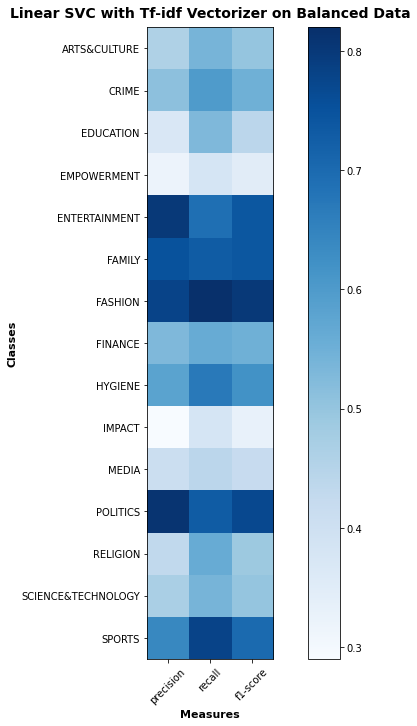

In [235]:
tfidf_lsvc_cw_ClassificationReport = """             precision    recall  f1-score   support

        ARTS&CULTURE       0.46      0.54      0.50       992
               CRIME       0.51      0.60      0.55       856
           EDUCATION       0.37      0.53      0.44       550
         EMPOWERMENT       0.32      0.38      0.35      1213
       ENTERTAINMENT       0.80      0.69      0.74      9870
              FAMILY       0.75      0.73      0.74      4984
             FASHION       0.78      0.82      0.80      2982
             FINANCE       0.53      0.56      0.55      1951
             HYGIENE       0.58      0.67      0.62      2050
              IMPACT       0.29      0.38      0.33       865
               MEDIA       0.41      0.44      0.42      1717
            POLITICS       0.81      0.73      0.77      8061
            RELIGION       0.43      0.56      0.49       601
  SCIENCE&TECHNOLOGY       0.47      0.54      0.50      1073
              SPORTS       0.64      0.78      0.70      1180
              VOICES       0.64      0.60      0.62      2981
            WELLNESS       0.75      0.74      0.75      6175
          WORLD NEWS       0.65      0.70      0.68      2113"""


tfidf_lsvc_cw_crplot = plot_classification_report(tfidf_lsvc_cw_ClassificationReport, title="Linear SVC with Tf-idf Vectorizer on Balanced Data")
tfidf_lsvc_cw_crplot


### Word2Vec

#### Imbalanced Data

In [261]:
clf_w2v_lsvc = LinearSVC()

# Feed the training data through the pipeline
clf_w2v_lsvc.fit(X_w2v_train, y_w2v_train)

LinearSVC()

In [265]:
predictions = clf_w2v_lsvc.predict(X_w2v_test)

print(metrics.classification_report(y_w2v_test,predictions))

w2v_lsvc_acc = metrics.accuracy_score(y_w2v_test,predictions)
print("Accuracy: " + str(w2v_lsvc_acc))

                      precision    recall  f1-score   support

      ARTS & CULTURE       0.60      0.11      0.18       992
               CRIME       0.50      0.46      0.48       856
           EDUCATION       0.48      0.16      0.24       550
         EMPOWERMENT       0.53      0.03      0.05      1213
       ENTERTAINMENT       0.57      0.76      0.65      9870
              FAMILY       0.57      0.67      0.62      4984
             FASHION       0.69      0.72      0.70      2982
             FINANCE       0.50      0.37      0.43      1951
             HYGIENE       0.53      0.35      0.42      2050
              IMPACT       0.53      0.01      0.02       865
               MEDIA       0.44      0.03      0.05      1717
            POLITICS       0.65      0.82      0.73      8061
            RELIGION       0.65      0.14      0.23       601
SCIENCE & TECHNOLOGY       0.55      0.15      0.24      1073
              SPORTS       0.63      0.56      0.59      1180
       

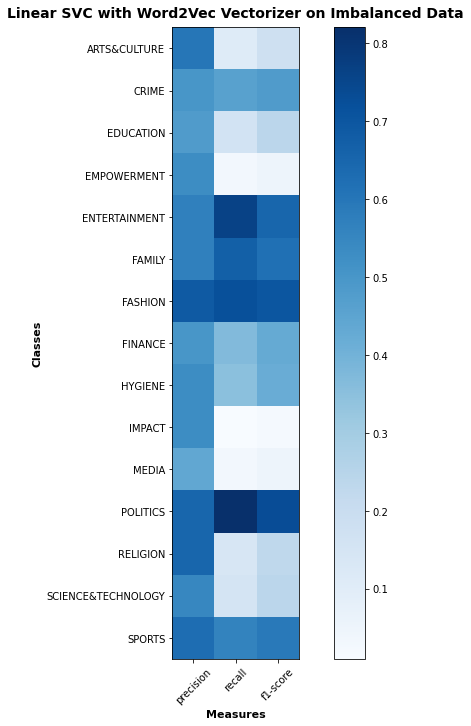

In [266]:
w2v_lsvc_ClassificationReport = """             precision    recall  f1-score   support

        ARTS&CULTURE       0.60      0.11      0.18       992
               CRIME       0.50      0.46      0.48       856
           EDUCATION       0.48      0.16      0.24       550
         EMPOWERMENT       0.53      0.03      0.05      1213
       ENTERTAINMENT       0.57      0.76      0.65      9870
              FAMILY       0.57      0.67      0.62      4984
             FASHION       0.69      0.72      0.70      2982
             FINANCE       0.50      0.37      0.43      1951
             HYGIENE       0.53      0.35      0.42      2050
              IMPACT       0.53      0.01      0.02       865
               MEDIA       0.44      0.03      0.05      1717
            POLITICS       0.65      0.82      0.73      8061
            RELIGION       0.65      0.14      0.23       601
  SCIENCE&TECHNOLOGY       0.55      0.15      0.24      1073
              SPORTS       0.63      0.56      0.59      1180
              VOICES       0.49      0.34      0.40      2981
            WELLNESS       0.59      0.79      0.67      6175
          WORLD NEWS       0.60      0.58      0.59      2113"""


w2v_lsvc_crplot = plot_classification_report(w2v_lsvc_ClassificationReport, title="Linear SVC with Word2Vec Vectorizer on Imbalanced Data")
w2v_lsvc_crplot

#### Balanced Data

In [264]:
clf_w2v_lsvc_cw = LinearSVC(class_weight='balanced')

# Feed the training data through the pipeline
clf_w2v_lsvc_cw.fit(X_w2v_train, y_w2v_train)

/usr/local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(class_weight='balanced')

In [267]:
predictions = clf_w2v_lsvc_cw.predict(X_w2v_test)

print(metrics.classification_report(y_w2v_test,predictions))

w2v_lsvc_cw_acc = metrics.accuracy_score(y_w2v_test,predictions)
print("Accuracy: " + str(w2v_lsvc_cw_acc))

                      precision    recall  f1-score   support

      ARTS & CULTURE       0.29      0.51      0.37       992
               CRIME       0.35      0.74      0.47       856
           EDUCATION       0.27      0.65      0.38       550
         EMPOWERMENT       0.29      0.17      0.22      1213
       ENTERTAINMENT       0.74      0.50      0.60      9870
              FAMILY       0.63      0.63      0.63      4984
             FASHION       0.64      0.78      0.70      2982
             FINANCE       0.44      0.52      0.48      1951
             HYGIENE       0.44      0.48      0.46      2050
              IMPACT       0.26      0.25      0.26       865
               MEDIA       0.34      0.14      0.19      1717
            POLITICS       0.77      0.69      0.73      8061
            RELIGION       0.24      0.50      0.33       601
SCIENCE & TECHNOLOGY       0.29      0.43      0.35      1073
              SPORTS       0.43      0.77      0.55      1180
       

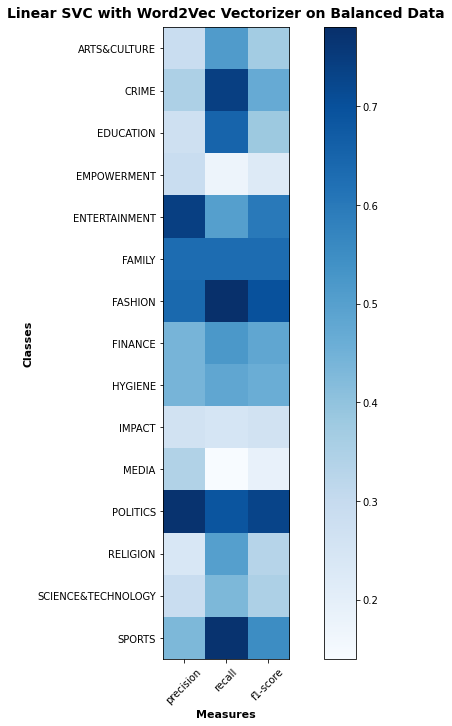

In [268]:
w2v_lsvc_cw_ClassificationReport = """             precision    recall  f1-score   support

        ARTS&CULTURE       0.29      0.51      0.37       992
               CRIME       0.35      0.74      0.47       856
           EDUCATION       0.27      0.65      0.38       550
         EMPOWERMENT       0.29      0.17      0.22      1213
       ENTERTAINMENT       0.74      0.50      0.60      9870
              FAMILY       0.63      0.63      0.63      4984
             FASHION       0.64      0.78      0.70      2982
             FINANCE       0.44      0.52      0.48      1951
             HYGIENE       0.44      0.48      0.46      2050
              IMPACT       0.26      0.25      0.26       865
               MEDIA       0.34      0.14      0.19      1717
            POLITICS       0.77      0.69      0.73      8061
            RELIGION       0.24      0.50      0.33       601
  SCIENCE&TECHNOLOGY       0.29      0.43      0.35      1073
              SPORTS       0.43      0.77      0.55      1180
              VOICES       0.53      0.37      0.44      2981
            WELLNESS       0.69      0.70      0.69      6175
          WORLD NEWS       0.54      0.68      0.60      2113"""


w2v_lsvc_cw_crplot = plot_classification_report(w2v_lsvc_cw_ClassificationReport, title="Linear SVC with Word2Vec Vectorizer on Balanced Data")
w2v_lsvc_cw_crplot


## Linear SVC Performance

In [270]:
lsvc_balanced_accuracies = {'Count Vec': cvec_lsvc_cw_acc, 'Tf-Idf Vec': tfidf_lsvc_cw_acc, 'Word2Vec': w2v_lsvc_cw_acc}
lsvc_imbalanced_accuracies = {'Count Vec': cvec_lsvc_acc, 'Tf-Idf Vec': tfidf_lsvc_acc, 'Word2Vec': w2v_lsvc_acc}


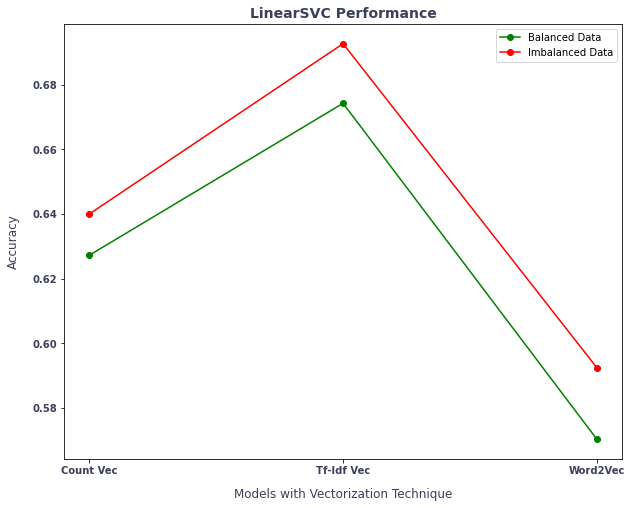

In [287]:
x = list(lsvc_balanced_accuracies.keys())
y_bal = list(lsvc_balanced_accuracies.values())
y_imbal = list(lsvc_imbalanced_accuracies.values())
plt.figure(figsize=(10,8))
plt.plot(x, y_bal, label= "Balanced Data", color='green', marker='o')
plt.plot(x, y_imbal, label= "Imbalanced Data", color='red', marker='o')
plt.title('LinearSVC Performance', fontweight="bold", fontsize=14, color="#3D405B")
plt.xlabel('Models with Vectorization Technique', fontsize = 12, labelpad=12, color="#3D405B")
plt.ylabel('Accuracy', fontsize=12, labelpad=12, color="#3D405B")
plt.xticks(fontweight="bold", fontsize=10, color="#3D405B")
plt.yticks(fontweight="bold", fontsize=10, color="#3D405B")
plt.legend()
plt.show()

----------

## Logistic Regression

### Count Vectorization

#### Imbalanced Data

In [288]:
clf_cvec_lr = Pipeline([('cvec', CountVectorizer()),('clf', LogisticRegression())])

# Feed the training data through the pipeline
clf_cvec_lr.fit(X_train, y_train)

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('cvec', CountVectorizer()), ('clf', LogisticRegression())])

In [289]:
predictions = clf_cvec_lr.predict(X_test)
print(metrics.classification_report(y_test,predictions))
cvec_lr_acc = metrics.accuracy_score(y_test,predictions)
print("Accuracy: " + str(cvec_lr_acc))

                      precision    recall  f1-score   support

      ARTS & CULTURE       0.58      0.39      0.47       992
               CRIME       0.60      0.48      0.53       856
           EDUCATION       0.51      0.35      0.41       550
         EMPOWERMENT       0.39      0.27      0.32      1213
       ENTERTAINMENT       0.66      0.80      0.72      9870
              FAMILY       0.73      0.72      0.73      4984
             FASHION       0.81      0.77      0.79      2982
             FINANCE       0.58      0.47      0.52      1951
             HYGIENE       0.62      0.58      0.60      2050
              IMPACT       0.38      0.27      0.32       865
               MEDIA       0.47      0.38      0.42      1717
            POLITICS       0.73      0.79      0.76      8061
            RELIGION       0.56      0.37      0.44       601
SCIENCE & TECHNOLOGY       0.59      0.41      0.48      1073
              SPORTS       0.69      0.64      0.66      1180
       

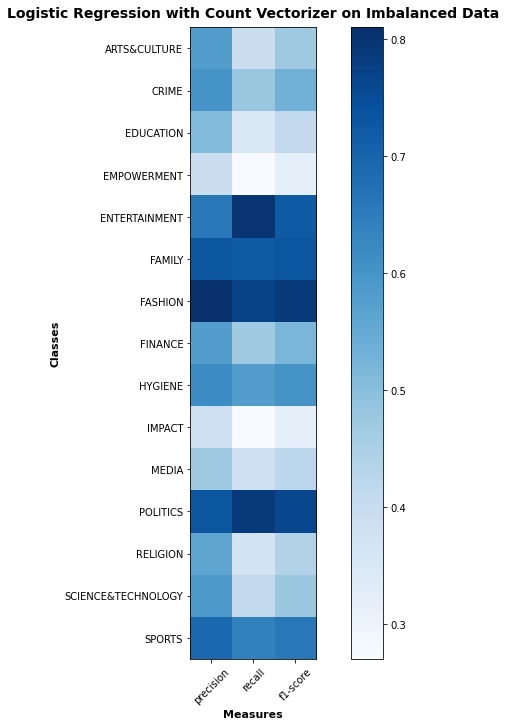

In [290]:
cvec_lr_ClassificationReport = """             precision    recall  f1-score   support

        ARTS&CULTURE       0.58      0.39      0.47       992
               CRIME       0.60      0.48      0.53       856
           EDUCATION       0.51      0.35      0.41       550
         EMPOWERMENT       0.39      0.27      0.32      1213
       ENTERTAINMENT       0.66      0.80      0.72      9870
              FAMILY       0.73      0.72      0.73      4984
             FASHION       0.81      0.77      0.79      2982
             FINANCE       0.58      0.47      0.52      1951
             HYGIENE       0.62      0.58      0.60      2050
              IMPACT       0.38      0.27      0.32       865
               MEDIA       0.47      0.38      0.42      1717
            POLITICS       0.73      0.79      0.76      8061
            RELIGION       0.56      0.37      0.44       601
  SCIENCE&TECHNOLOGY       0.59      0.41      0.48      1073
              SPORTS       0.69      0.64      0.66      1180
              VOICES       0.62      0.55      0.58      2981
            WELLNESS       0.70      0.76      0.73      6175
          WORLD NEWS       0.68      0.64      0.66      2113"""


cvec_lr_crplot = plot_classification_report(cvec_lr_ClassificationReport, title="Logistic Regression with Count Vectorizer on Imbalanced Data")
cvec_lr_crplot

#### Balanced Data

In [291]:
clf_cvec_lr_cw = Pipeline([('cvec', CountVectorizer()),('clf', LogisticRegression(class_weight='balanced'))])

# Feed the training data through the pipeline
clf_cvec_lr_cw.fit(X_train, y_train)

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('cvec', CountVectorizer()),
                ('clf', LogisticRegression(class_weight='balanced'))])

In [292]:
predictions = clf_cvec_lr_cw.predict(X_test)
print(metrics.classification_report(y_test,predictions))
cvec_lr_cw_acc = metrics.accuracy_score(y_test,predictions)
print("Accuracy: " + str(cvec_lr_cw_acc))

                      precision    recall  f1-score   support

      ARTS & CULTURE       0.39      0.58      0.47       992
               CRIME       0.45      0.62      0.52       856
           EDUCATION       0.33      0.54      0.41       550
         EMPOWERMENT       0.26      0.44      0.32      1213
       ENTERTAINMENT       0.80      0.61      0.69      9870
              FAMILY       0.77      0.66      0.71      4984
             FASHION       0.77      0.79      0.78      2982
             FINANCE       0.50      0.56      0.53      1951
             HYGIENE       0.55      0.66      0.60      2050
              IMPACT       0.23      0.40      0.30       865
               MEDIA       0.32      0.50      0.39      1717
            POLITICS       0.83      0.66      0.74      8061
            RELIGION       0.40      0.56      0.47       601
SCIENCE & TECHNOLOGY       0.40      0.57      0.47      1073
              SPORTS       0.56      0.75      0.65      1180
       

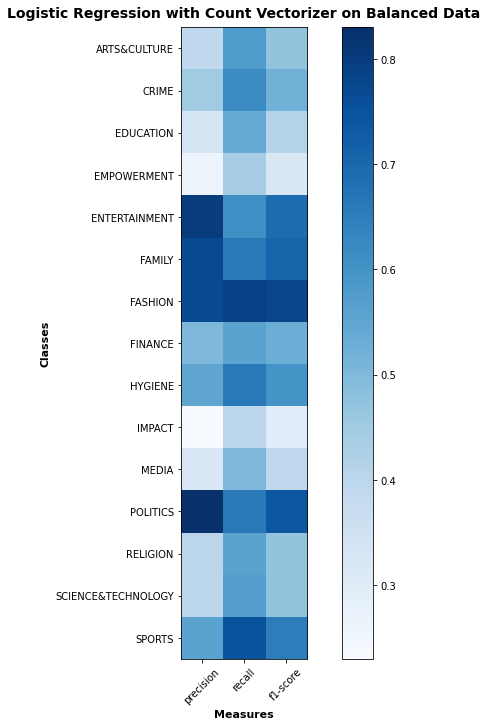

In [293]:
cvec_lr_cw_ClassificationReport = """             precision    recall  f1-score   support

        ARTS&CULTURE       0.39      0.58      0.47       992
               CRIME       0.45      0.62      0.52       856
           EDUCATION       0.33      0.54      0.41       550
         EMPOWERMENT       0.26      0.44      0.32      1213
       ENTERTAINMENT       0.80      0.61      0.69      9870
              FAMILY       0.77      0.66      0.71      4984
             FASHION       0.77      0.79      0.78      2982
             FINANCE       0.50      0.56      0.53      1951
             HYGIENE       0.55      0.66      0.60      2050
              IMPACT       0.23      0.40      0.30       865
               MEDIA       0.32      0.50      0.39      1717
            POLITICS       0.83      0.66      0.74      8061
            RELIGION       0.40      0.56      0.47       601
  SCIENCE&TECHNOLOGY       0.40      0.57      0.47      1073
              SPORTS       0.56      0.75      0.65      1180
              VOICES       0.57      0.58      0.58      2981
            WELLNESS       0.76      0.64      0.70      6175
          WORLD NEWS       0.62      0.69      0.65      2113"""


cvec_lr_cw_crplot = plot_classification_report(cvec_lr_cw_ClassificationReport, title="Logistic Regression with Count Vectorizer on Balanced Data")
cvec_lr_cw_crplot

### Tf-idf Vectorization

#### Imbalanced Data

In [294]:
clf_tfidf_lr = Pipeline([('tfidf', TfidfVectorizer()), ('clf', LogisticRegression())])

# Feed the training data through the pipeline
clf_tfidf_lr.fit(X_train, y_train)

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LogisticRegression())])

In [295]:
predictions = clf_tfidf_lr.predict(X_test)
print(metrics.classification_report(y_test,predictions))
tfidf_lr_acc = metrics.accuracy_score(y_test,predictions)
print("Accuracy: " + str(tfidf_lr_acc))

                      precision    recall  f1-score   support

      ARTS & CULTURE       0.65      0.33      0.44       992
               CRIME       0.65      0.46      0.54       856
           EDUCATION       0.55      0.33      0.41       550
         EMPOWERMENT       0.47      0.25      0.32      1213
       ENTERTAINMENT       0.63      0.84      0.72      9870
              FAMILY       0.73      0.74      0.73      4984
             FASHION       0.81      0.75      0.78      2982
             FINANCE       0.63      0.46      0.54      1951
             HYGIENE       0.68      0.56      0.61      2050
              IMPACT       0.50      0.23      0.31       865
               MEDIA       0.55      0.30      0.39      1717
            POLITICS       0.71      0.82      0.76      8061
            RELIGION       0.61      0.34      0.44       601
SCIENCE & TECHNOLOGY       0.65      0.38      0.48      1073
              SPORTS       0.74      0.59      0.66      1180
       

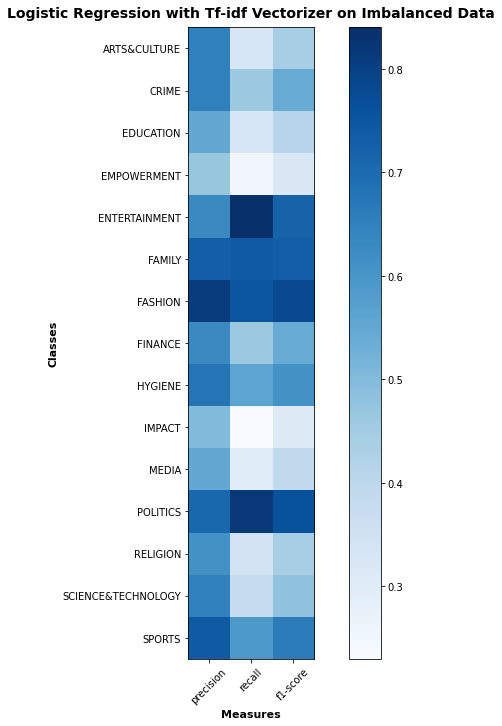

In [296]:
tfidf_lr_ClassificationReport = """             precision    recall  f1-score   support

        ARTS&CULTURE       0.65      0.33      0.44       992
               CRIME       0.65      0.46      0.54       856
           EDUCATION       0.55      0.33      0.41       550
         EMPOWERMENT       0.47      0.25      0.32      1213
       ENTERTAINMENT       0.63      0.84      0.72      9870
              FAMILY       0.73      0.74      0.73      4984
             FASHION       0.81      0.75      0.78      2982
             FINANCE       0.63      0.46      0.54      1951
             HYGIENE       0.68      0.56      0.61      2050
              IMPACT       0.50      0.23      0.31       865
               MEDIA       0.55      0.30      0.39      1717
            POLITICS       0.71      0.82      0.76      8061
            RELIGION       0.61      0.34      0.44       601
  SCIENCE&TECHNOLOGY       0.65      0.38      0.48      1073
              SPORTS       0.74      0.59      0.66      1180
              VOICES       0.68      0.51      0.58      2981
            WELLNESS       0.67      0.80      0.73      6175
          WORLD NEWS       0.73      0.62      0.67      2113"""


tfidf_lr_crplot = plot_classification_report(tfidf_lr_ClassificationReport, title="Logistic Regression with Tf-idf Vectorizer on Imbalanced Data")
tfidf_lr_crplot

#### Balanced Data

In [297]:
clf_tfidf_lr_cw = Pipeline([('tfidf', TfidfVectorizer()), ('clf', LogisticRegression(class_weight='balanced'))])

# Feed the training data through the pipeline
clf_tfidf_lr_cw.fit(X_train, y_train)

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', LogisticRegression(class_weight='balanced'))])

In [298]:
predictions = clf_tfidf_lr_cw.predict(X_test)
print(metrics.classification_report(y_test,predictions))
tfidf_lr_cw_acc = metrics.accuracy_score(y_test,predictions)
print("Accuracy: " + str(tfidf_lr_cw_acc))

                      precision    recall  f1-score   support

      ARTS & CULTURE       0.40      0.65      0.49       992
               CRIME       0.44      0.69      0.54       856
           EDUCATION       0.35      0.64      0.45       550
         EMPOWERMENT       0.28      0.49      0.36      1213
       ENTERTAINMENT       0.82      0.59      0.69      9870
              FAMILY       0.77      0.68      0.72      4984
             FASHION       0.78      0.81      0.79      2982
             FINANCE       0.51      0.59      0.54      1951
             HYGIENE       0.55      0.69      0.61      2050
              IMPACT       0.27      0.48      0.34       865
               MEDIA       0.37      0.50      0.42      1717
            POLITICS       0.84      0.66      0.74      8061
            RELIGION       0.42      0.64      0.51       601
SCIENCE & TECHNOLOGY       0.41      0.62      0.50      1073
              SPORTS       0.59      0.80      0.68      1180
       

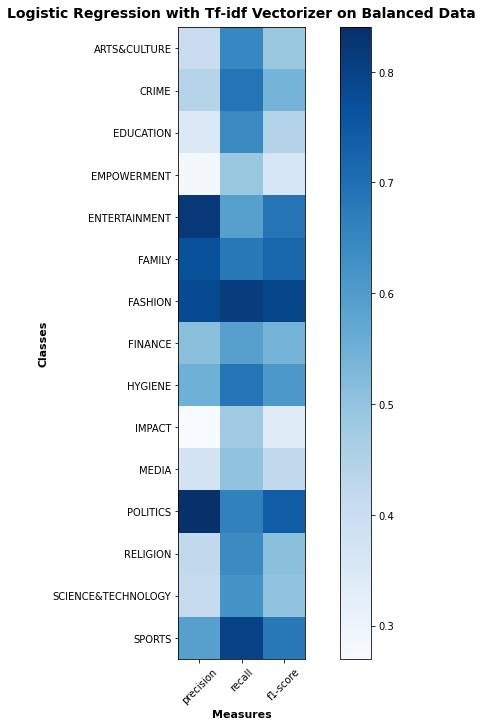

In [299]:
tfidf_lr_cw_ClassificationReport = """             precision    recall  f1-score   support

        ARTS&CULTURE       0.40      0.65      0.49       992
               CRIME       0.44      0.69      0.54       856
           EDUCATION       0.35      0.64      0.45       550
         EMPOWERMENT       0.28      0.49      0.36      1213
       ENTERTAINMENT       0.82      0.59      0.69      9870
              FAMILY       0.77      0.68      0.72      4984
             FASHION       0.78      0.81      0.79      2982
             FINANCE       0.51      0.59      0.54      1951
             HYGIENE       0.55      0.69      0.61      2050
              IMPACT       0.27      0.48      0.34       865
               MEDIA       0.37      0.50      0.42      1717
            POLITICS       0.84      0.66      0.74      8061
            RELIGION       0.42      0.64      0.51       601
  SCIENCE&TECHNOLOGY       0.41      0.62      0.50      1073
              SPORTS       0.59      0.80      0.68      1180
              VOICES       0.62      0.56      0.59      2981
            WELLNESS       0.77      0.67      0.72      6175
          WORLD NEWS       0.62      0.70      0.66      2113"""


tfidf_lr_cw_crplot = plot_classification_report(tfidf_lr_cw_ClassificationReport, title="Logistic Regression with Tf-idf Vectorizer on Balanced Data")
tfidf_lr_cw_crplot

### Word2Vec

#### Imbalanced Data

In [301]:
clf_w2v_lr = LogisticRegression()

# Feed the training data through the pipeline
clf_w2v_lr.fit(X_w2v_train, y_w2v_train)

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [302]:
predictions = clf_w2v_lr.predict(X_w2v_test)
print(metrics.classification_report(y_w2v_test,predictions))
w2v_lr_acc = metrics.accuracy_score(y_w2v_test,predictions)
print("Accuracy: " + str(w2v_lr_acc))

                      precision    recall  f1-score   support

      ARTS & CULTURE       0.49      0.27      0.35       992
               CRIME       0.54      0.46      0.50       856
           EDUCATION       0.48      0.29      0.36       550
         EMPOWERMENT       0.39      0.13      0.20      1213
       ENTERTAINMENT       0.59      0.74      0.66      9870
              FAMILY       0.60      0.66      0.63      4984
             FASHION       0.74      0.69      0.71      2982
             FINANCE       0.52      0.44      0.48      1951
             HYGIENE       0.52      0.42      0.47      2050
              IMPACT       0.37      0.17      0.23       865
               MEDIA       0.35      0.14      0.20      1717
            POLITICS       0.68      0.78      0.73      8061
            RELIGION       0.50      0.30      0.38       601
SCIENCE & TECHNOLOGY       0.50      0.30      0.38      1073
              SPORTS       0.64      0.56      0.59      1180
       

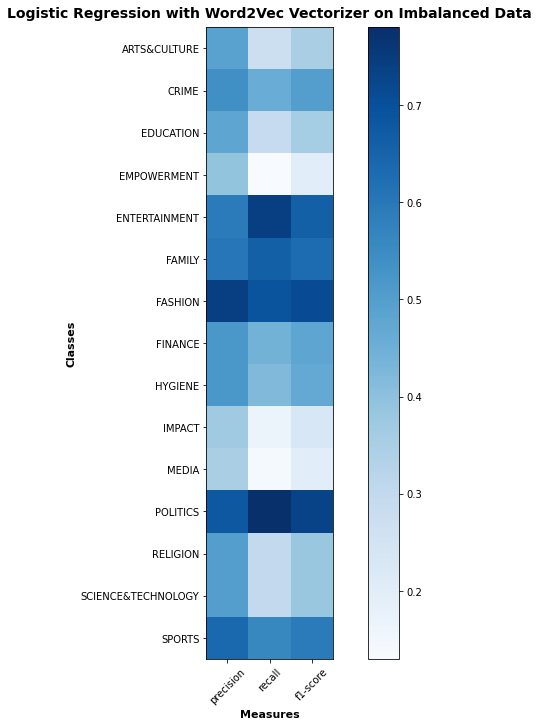

In [303]:
w2v_lr_ClassificationReport = """             precision    recall  f1-score   support

        ARTS&CULTURE       0.49      0.27      0.35       992
               CRIME       0.54      0.46      0.50       856
           EDUCATION       0.48      0.29      0.36       550
         EMPOWERMENT       0.39      0.13      0.20      1213
       ENTERTAINMENT       0.59      0.74      0.66      9870
              FAMILY       0.60      0.66      0.63      4984
             FASHION       0.74      0.69      0.71      2982
             FINANCE       0.52      0.44      0.48      1951
             HYGIENE       0.52      0.42      0.47      2050
              IMPACT       0.37      0.17      0.23       865
               MEDIA       0.35      0.14      0.20      1717
            POLITICS       0.68      0.78      0.73      8061
            RELIGION       0.50      0.30      0.38       601
  SCIENCE&TECHNOLOGY       0.50      0.30      0.38      1073
              SPORTS       0.64      0.56      0.59      1180
              VOICES       0.50      0.42      0.46      2981
            WELLNESS       0.63      0.77      0.69      6175
          WORLD NEWS       0.63      0.59      0.61      2113"""


w2v_lr_crplot = plot_classification_report(w2v_lr_ClassificationReport, title="Logistic Regression with Word2Vec Vectorizer on Imbalanced Data")
w2v_lr_crplot


#### Balanced Data

In [304]:
clf_w2v_lr_cw = LogisticRegression(class_weight='balanced')

# Feed the training data through the pipeline
clf_w2v_lr_cw.fit(X_w2v_train, y_w2v_train)

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced')

In [305]:
predictions = clf_w2v_lr_cw.predict(X_w2v_test)
print(metrics.classification_report(y_w2v_test,predictions))
w2v_lr_cw_acc = metrics.accuracy_score(y_w2v_test,predictions)
print("Accuracy: " + str(w2v_lr_cw_acc))

                      precision    recall  f1-score   support

      ARTS & CULTURE       0.25      0.56      0.35       992
               CRIME       0.37      0.70      0.49       856
           EDUCATION       0.26      0.66      0.37       550
         EMPOWERMENT       0.20      0.34      0.25      1213
       ENTERTAINMENT       0.77      0.42      0.54      9870
              FAMILY       0.66      0.56      0.61      4984
             FASHION       0.67      0.75      0.71      2982
             FINANCE       0.44      0.52      0.47      1951
             HYGIENE       0.40      0.50      0.45      2050
              IMPACT       0.19      0.41      0.26       865
               MEDIA       0.23      0.30      0.26      1717
            POLITICS       0.83      0.58      0.68      8061
            RELIGION       0.22      0.55      0.31       601
SCIENCE & TECHNOLOGY       0.27      0.49      0.35      1073
              SPORTS       0.45      0.73      0.56      1180
       

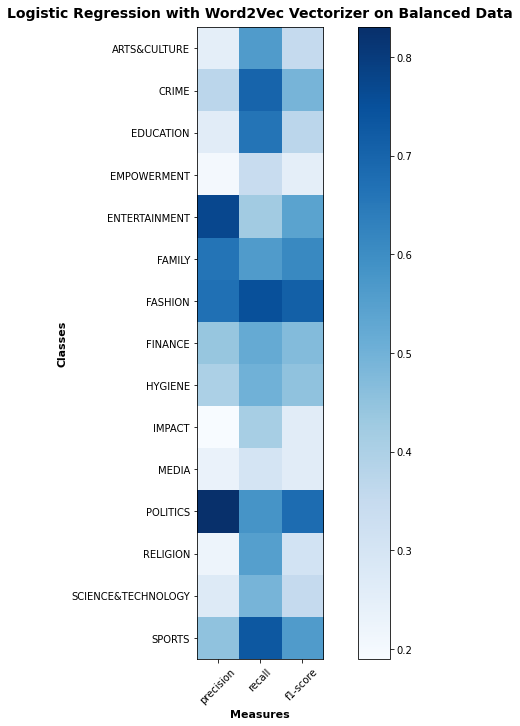

In [306]:
w2v_lr_cw_ClassificationReport = """             precision    recall  f1-score   support

        ARTS&CULTURE       0.25      0.56      0.35       992
               CRIME       0.37      0.70      0.49       856
           EDUCATION       0.26      0.66      0.37       550
         EMPOWERMENT       0.20      0.34      0.25      1213
       ENTERTAINMENT       0.77      0.42      0.54      9870
              FAMILY       0.66      0.56      0.61      4984
             FASHION       0.67      0.75      0.71      2982
             FINANCE       0.44      0.52      0.47      1951
             HYGIENE       0.40      0.50      0.45      2050
              IMPACT       0.19      0.41      0.26       865
               MEDIA       0.23      0.30      0.26      1717
            POLITICS       0.83      0.58      0.68      8061
            RELIGION       0.22      0.55      0.31       601
  SCIENCE&TECHNOLOGY       0.27      0.49      0.35      1073
              SPORTS       0.45      0.73      0.56      1180
              VOICES       0.48      0.40      0.43      2981
            WELLNESS       0.74      0.59      0.66      6175
          WORLD NEWS       0.56      0.64      0.60      2113"""


w2v_lr_cw_crplot = plot_classification_report(w2v_lr_cw_ClassificationReport, title="Logistic Regression with Word2Vec Vectorizer on Balanced Data")
w2v_lr_cw_crplot


## Logistic Regression Performance

In [308]:
lr_balanced_accuracies = {'Count Vec': cvec_lr_cw_acc, 'Tf-Idf Vec': tfidf_lr_cw_acc, 'Word2Vec': w2v_lr_cw_acc}
lr_imbalanced_accuracies = {'Count Vec': cvec_lr_acc, 'Tf-Idf Vec': tfidf_lr_acc, 'Word2Vec': w2v_lr_acc}


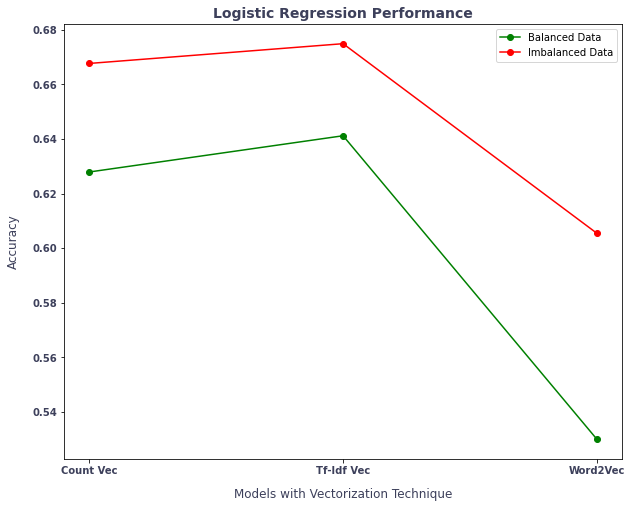

In [309]:
x = list(lr_balanced_accuracies.keys())
y_bal = list(lr_balanced_accuracies.values())
y_imbal = list(lr_imbalanced_accuracies.values())
plt.figure(figsize=(10,8))
plt.plot(x, y_bal, label= "Balanced Data", color='green', marker='o')
plt.plot(x, y_imbal, label= "Imbalanced Data", color='red', marker='o')
plt.title('Logistic Regression Performance', fontweight="bold", fontsize=14, color="#3D405B")
plt.xlabel('Models with Vectorization Technique', fontsize = 12, labelpad=12, color="#3D405B")
plt.ylabel('Accuracy', fontsize=12, labelpad=12, color="#3D405B")
plt.xticks(fontweight="bold", fontsize=10, color="#3D405B")
plt.yticks(fontweight="bold", fontsize=10, color="#3D405B")
plt.legend()
plt.show()

----

## Random Forest

### Count Vectorization

#### Imbalanced Data

In [317]:
clf_cvec_rf = Pipeline([('cvec', CountVectorizer()),('clf', RandomForestClassifier(max_depth=100))])

# Feed the training data through the pipeline
clf_cvec_rf.fit(X_train, y_train)

Pipeline(steps=[('cvec', CountVectorizer()),
                ('clf', RandomForestClassifier(max_depth=100))])

In [318]:
predictions = clf_cvec_rf.predict(X_test)
print(metrics.classification_report(y_test,predictions))
cvec_rf_acc = metrics.accuracy_score(y_test,predictions)
print("Accuracy: " + str(cvec_rf_acc))

                      precision    recall  f1-score   support

      ARTS & CULTURE       0.88      0.04      0.07       992
               CRIME       0.74      0.09      0.16       856
           EDUCATION       0.73      0.01      0.03       550
         EMPOWERMENT       1.00      0.02      0.04      1213
       ENTERTAINMENT       0.37      0.88      0.52      9870
              FAMILY       0.70      0.65      0.67      4984
             FASHION       0.86      0.56      0.68      2982
             FINANCE       0.93      0.05      0.10      1951
             HYGIENE       0.94      0.13      0.24      2050
              IMPACT       1.00      0.00      0.00       865
               MEDIA       1.00      0.01      0.01      1717
            POLITICS       0.61      0.84      0.70      8061
            RELIGION       0.87      0.07      0.14       601
SCIENCE & TECHNOLOGY       1.00      0.04      0.07      1073
              SPORTS       0.83      0.10      0.18      1180
       

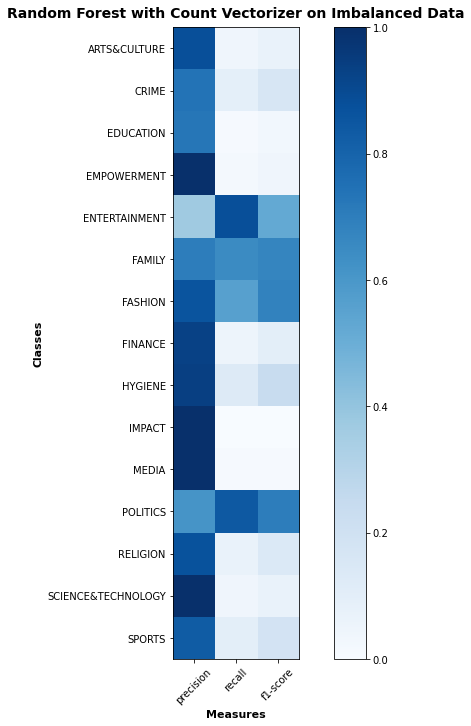

In [320]:
cvec_rf_ClassificationReport = """             precision    recall  f1-score   support

        ARTS&CULTURE       0.88      0.04      0.07       992
               CRIME       0.74      0.09      0.16       856
           EDUCATION       0.73      0.01      0.03       550
         EMPOWERMENT       1.00      0.02      0.04      1213
       ENTERTAINMENT       0.37      0.88      0.52      9870
              FAMILY       0.70      0.65      0.67      4984
             FASHION       0.86      0.56      0.68      2982
             FINANCE       0.93      0.05      0.10      1951
             HYGIENE       0.94      0.13      0.24      2050
              IMPACT       1.00      0.00      0.00       865
               MEDIA       1.00      0.01      0.01      1717
            POLITICS       0.61      0.84      0.70      8061
            RELIGION       0.87      0.07      0.14       601
  SCIENCE&TECHNOLOGY       1.00      0.04      0.07      1073
              SPORTS       0.83      0.10      0.18      1180
              VOICES       0.82      0.25      0.38      2981
            WELLNESS       0.59      0.69      0.64      6175
          WORLD NEWS       0.85      0.17      0.28      2113"""


cvec_rf_crplot = plot_classification_report(cvec_rf_ClassificationReport, title="Random Forest with Count Vectorizer on Imbalanced Data")
cvec_rf_crplot


#### Balanced Data

In [321]:
clf_cvec_rf_cw = Pipeline([('cvec', CountVectorizer()),('clf', RandomForestClassifier(max_depth=100, class_weight='balanced'))])

# Feed the training data through the pipeline
clf_cvec_rf_cw.fit(X_train, y_train)

Pipeline(steps=[('cvec', CountVectorizer()),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        max_depth=100))])

In [322]:
predictions = clf_cvec_rf_cw.predict(X_test)
print(metrics.classification_report(y_test,predictions))
cvec_rf_cw_acc = metrics.accuracy_score(y_test,predictions)
print("Accuracy: " + str(cvec_rf_cw_acc))

                      precision    recall  f1-score   support

      ARTS & CULTURE       0.47      0.40      0.43       992
               CRIME       0.33      0.62      0.43       856
           EDUCATION       0.34      0.50      0.41       550
         EMPOWERMENT       0.36      0.23      0.28      1213
       ENTERTAINMENT       0.62      0.47      0.53      9870
              FAMILY       0.61      0.73      0.66      4984
             FASHION       0.61      0.74      0.67      2982
             FINANCE       0.49      0.35      0.41      1951
             HYGIENE       0.57      0.42      0.49      2050
              IMPACT       0.51      0.11      0.18       865
               MEDIA       0.19      0.26      0.22      1717
            POLITICS       0.68      0.72      0.70      8061
            RELIGION       0.47      0.45      0.46       601
SCIENCE & TECHNOLOGY       0.48      0.35      0.40      1073
              SPORTS       0.49      0.67      0.57      1180
       

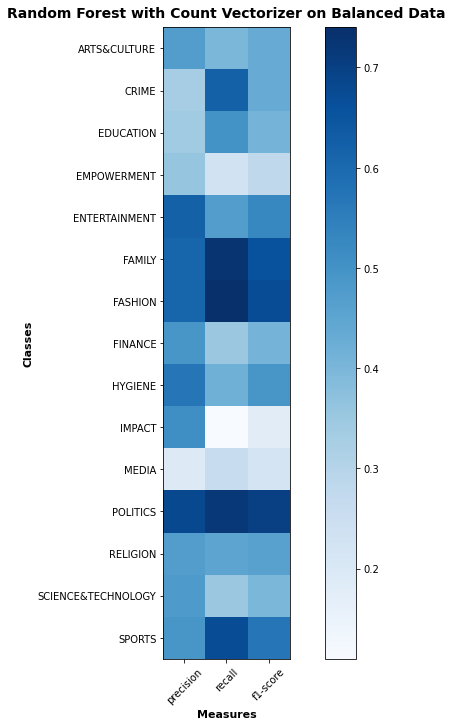

In [323]:
cvec_rf_cw_ClassificationReport = """             precision    recall  f1-score   support

        ARTS&CULTURE       0.47      0.40      0.43       992
               CRIME       0.33      0.62      0.43       856
           EDUCATION       0.34      0.50      0.41       550
         EMPOWERMENT       0.36      0.23      0.28      1213
       ENTERTAINMENT       0.62      0.47      0.53      9870
              FAMILY       0.61      0.73      0.66      4984
             FASHION       0.61      0.74      0.67      2982
             FINANCE       0.49      0.35      0.41      1951
             HYGIENE       0.57      0.42      0.49      2050
              IMPACT       0.51      0.11      0.18       865
               MEDIA       0.19      0.26      0.22      1717
            POLITICS       0.68      0.72      0.70      8061
            RELIGION       0.47      0.45      0.46       601
  SCIENCE&TECHNOLOGY       0.48      0.35      0.40      1073
              SPORTS       0.49      0.67      0.57      1180
              VOICES       0.67      0.39      0.49      2981
            WELLNESS       0.54      0.72      0.62      6175
          WORLD NEWS       0.51      0.51      0.51      2113"""


cvec_rf_cw_crplot = plot_classification_report(cvec_rf_cw_ClassificationReport, title="Random Forest with Count Vectorizer on Balanced Data")
cvec_rf_cw_crplot

### Tf-idf Vectorization

#### Imbalanced Data

In [324]:
clf_tfidf_rf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', RandomForestClassifier(max_depth=100))])

# Feed the training data through the pipeline
clf_tfidf_rf.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', RandomForestClassifier(max_depth=100))])

In [325]:
predictions = clf_tfidf_rf.predict(X_test)
print(metrics.classification_report(y_test,predictions))
tfidf_rf_acc = metrics.accuracy_score(y_test,predictions)
print("Accuracy: " + str(tfidf_rf_acc))

                      precision    recall  f1-score   support

      ARTS & CULTURE       0.82      0.02      0.05       992
               CRIME       0.73      0.09      0.16       856
           EDUCATION       0.83      0.01      0.02       550
         EMPOWERMENT       1.00      0.02      0.04      1213
       ENTERTAINMENT       0.37      0.88      0.52      9870
              FAMILY       0.71      0.64      0.67      4984
             FASHION       0.85      0.55      0.67      2982
             FINANCE       0.92      0.05      0.09      1951
             HYGIENE       0.95      0.14      0.25      2050
              IMPACT       1.00      0.00      0.00       865
               MEDIA       1.00      0.01      0.01      1717
            POLITICS       0.61      0.84      0.71      8061
            RELIGION       0.87      0.06      0.12       601
SCIENCE & TECHNOLOGY       0.97      0.03      0.05      1073
              SPORTS       0.81      0.10      0.17      1180
       

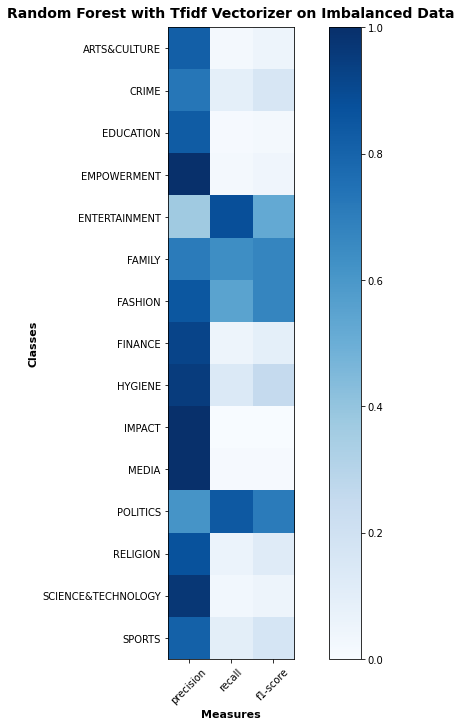

In [326]:
tfidf_rf_ClassificationReport = """             precision    recall  f1-score   support

        ARTS&CULTURE       0.82      0.02      0.05       992
               CRIME       0.73      0.09      0.16       856
           EDUCATION       0.83      0.01      0.02       550
         EMPOWERMENT       1.00      0.02      0.04      1213
       ENTERTAINMENT       0.37      0.88      0.52      9870
              FAMILY       0.71      0.64      0.67      4984
             FASHION       0.85      0.55      0.67      2982
             FINANCE       0.92      0.05      0.09      1951
             HYGIENE       0.95      0.14      0.25      2050
              IMPACT       1.00      0.00      0.00       865
               MEDIA       1.00      0.01      0.01      1717
            POLITICS       0.61      0.84      0.71      8061
            RELIGION       0.87      0.06      0.12       601
  SCIENCE&TECHNOLOGY       0.97      0.03      0.05      1073
              SPORTS       0.81      0.10      0.17      1180
              VOICES       0.83      0.25      0.39      2981
            WELLNESS       0.59      0.69      0.63      6175
          WORLD NEWS       0.86      0.18      0.30      2113"""


tfidf_rf_crplot = plot_classification_report(tfidf_rf_ClassificationReport, title="Random Forest with Tfidf Vectorizer on Imbalanced Data")
tfidf_rf_crplot


#### Balanced Data

In [328]:
clf_tfidf_rf_cw = Pipeline([('tfidf', TfidfVectorizer()), ('clf', RandomForestClassifier(max_depth=100, class_weight='balanced'))])

# Feed the training data through the pipeline
clf_tfidf_rf_cw.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        max_depth=100))])

In [329]:
predictions = clf_tfidf_rf_cw.predict(X_test)
print(metrics.classification_report(y_test,predictions))
tfidf_rf_cw_acc = metrics.accuracy_score(y_test,predictions)
print("Accuracy: " + str(tfidf_rf_cw_acc))

                      precision    recall  f1-score   support

      ARTS & CULTURE       0.43      0.41      0.42       992
               CRIME       0.35      0.63      0.45       856
           EDUCATION       0.36      0.50      0.42       550
         EMPOWERMENT       0.35      0.22      0.27      1213
       ENTERTAINMENT       0.61      0.45      0.52      9870
              FAMILY       0.60      0.72      0.65      4984
             FASHION       0.61      0.75      0.67      2982
             FINANCE       0.46      0.36      0.41      1951
             HYGIENE       0.57      0.42      0.49      2050
              IMPACT       0.46      0.10      0.16       865
               MEDIA       0.20      0.26      0.23      1717
            POLITICS       0.68      0.73      0.71      8061
            RELIGION       0.50      0.44      0.47       601
SCIENCE & TECHNOLOGY       0.46      0.36      0.40      1073
              SPORTS       0.50      0.67      0.57      1180
       

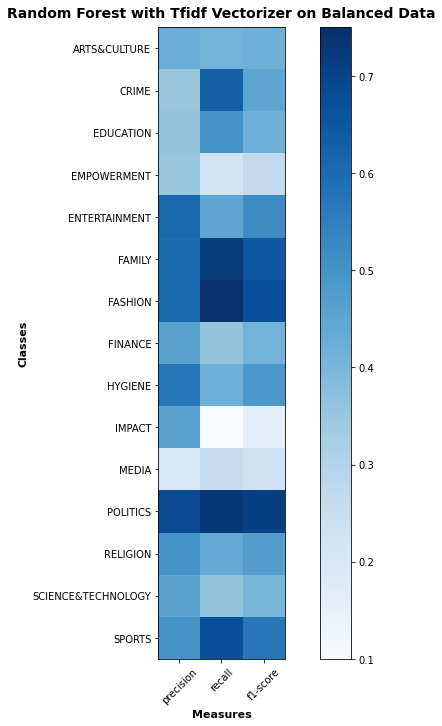

In [330]:
tfidf_rf_cw_ClassificationReport = """             precision    recall  f1-score   support

        ARTS&CULTURE       0.43      0.41      0.42       992
               CRIME       0.35      0.63      0.45       856
           EDUCATION       0.36      0.50      0.42       550
         EMPOWERMENT       0.35      0.22      0.27      1213
       ENTERTAINMENT       0.61      0.45      0.52      9870
              FAMILY       0.60      0.72      0.65      4984
             FASHION       0.61      0.75      0.67      2982
             FINANCE       0.46      0.36      0.41      1951
             HYGIENE       0.57      0.42      0.49      2050
              IMPACT       0.46      0.10      0.16       865
               MEDIA       0.20      0.26      0.23      1717
            POLITICS       0.68      0.73      0.71      8061
            RELIGION       0.50      0.44      0.47       601
  SCIENCE&TECHNOLOGY       0.46      0.36      0.40      1073
              SPORTS       0.50      0.67      0.57      1180
              VOICES       0.66      0.40      0.50      2981
            WELLNESS       0.53      0.72      0.61      6175
          WORLD NEWS       0.51      0.53      0.52      2113"""


tfidf_rf_cw_crplot = plot_classification_report(tfidf_rf_cw_ClassificationReport, title="Random Forest with Tfidf Vectorizer on Balanced Data")
tfidf_rf_cw_crplot


### Word2Vec

#### Imbalanced Data

In [331]:
clf_w2v_rf = RandomForestClassifier(max_depth=100)

# Feed the training data through the pipeline
clf_w2v_rf.fit(X_w2v_train, y_w2v_train)

RandomForestClassifier(max_depth=100)

In [333]:
predictions = clf_w2v_rf.predict(X_w2v_test)
print(metrics.classification_report(y_w2v_test,predictions))
w2v_rf_acc = metrics.accuracy_score(y_w2v_test,predictions)
print("Accuracy: " + str(w2v_rf_acc))

                      precision    recall  f1-score   support

      ARTS & CULTURE       0.65      0.13      0.22       992
               CRIME       0.55      0.46      0.50       856
           EDUCATION       0.55      0.14      0.23       550
         EMPOWERMENT       0.59      0.05      0.10      1213
       ENTERTAINMENT       0.55      0.83      0.66      9870
              FAMILY       0.61      0.65      0.63      4984
             FASHION       0.79      0.68      0.73      2982
             FINANCE       0.53      0.36      0.43      1951
             HYGIENE       0.66      0.37      0.48      2050
              IMPACT       0.42      0.05      0.08       865
               MEDIA       0.55      0.10      0.17      1717
            POLITICS       0.63      0.84      0.72      8061
            RELIGION       0.73      0.12      0.20       601
SCIENCE & TECHNOLOGY       0.66      0.21      0.31      1073
              SPORTS       0.74      0.45      0.56      1180
       

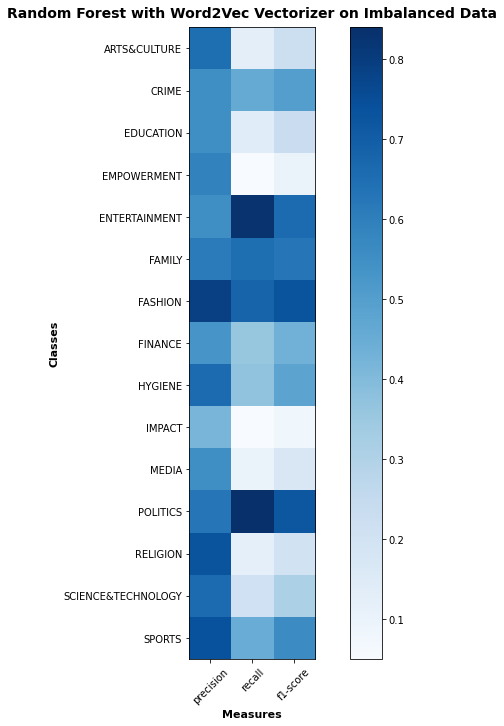

In [334]:
w2v_rf_ClassificationReport = """             precision    recall  f1-score   support

        ARTS&CULTURE       0.65      0.13      0.22       992
               CRIME       0.55      0.46      0.50       856
           EDUCATION       0.55      0.14      0.23       550
         EMPOWERMENT       0.59      0.05      0.10      1213
       ENTERTAINMENT       0.55      0.83      0.66      9870
              FAMILY       0.61      0.65      0.63      4984
             FASHION       0.79      0.68      0.73      2982
             FINANCE       0.53      0.36      0.43      1951
             HYGIENE       0.66      0.37      0.48      2050
              IMPACT       0.42      0.05      0.08       865
               MEDIA       0.55      0.10      0.17      1717
            POLITICS       0.63      0.84      0.72      8061
            RELIGION       0.73      0.12      0.20       601
  SCIENCE&TECHNOLOGY       0.66      0.21      0.31      1073
              SPORTS       0.74      0.45      0.56      1180
              VOICES       0.51      0.32      0.40      2981
            WELLNESS       0.62      0.79      0.69      6175
          WORLD NEWS       0.67      0.53      0.59      2113"""


w2v_rf_crplot = plot_classification_report(w2v_rf_ClassificationReport, title="Random Forest with Word2Vec Vectorizer on Imbalanced Data")
w2v_rf_crplot


#### Balanced Data

In [332]:
clf_w2v_rf_cw = RandomForestClassifier(max_depth=100, class_weight='balanced')

# Feed the training data through the pipeline
clf_w2v_rf_cw.fit(X_w2v_train, y_w2v_train)

RandomForestClassifier(class_weight='balanced', max_depth=100)

In [335]:
predictions = clf_w2v_rf_cw.predict(X_w2v_test)
print(metrics.classification_report(y_w2v_test,predictions))
w2v_rf_cw_acc = metrics.accuracy_score(y_w2v_test,predictions)
print("Accuracy: " + str(w2v_rf_cw_acc))

                      precision    recall  f1-score   support

      ARTS & CULTURE       0.65      0.15      0.24       992
               CRIME       0.54      0.47      0.50       856
           EDUCATION       0.52      0.24      0.33       550
         EMPOWERMENT       0.53      0.06      0.11      1213
       ENTERTAINMENT       0.53      0.83      0.65      9870
              FAMILY       0.62      0.63      0.63      4984
             FASHION       0.81      0.67      0.73      2982
             FINANCE       0.56      0.36      0.44      1951
             HYGIENE       0.70      0.37      0.48      2050
              IMPACT       0.38      0.07      0.12       865
               MEDIA       0.54      0.11      0.18      1717
            POLITICS       0.62      0.84      0.71      8061
            RELIGION       0.67      0.17      0.27       601
SCIENCE & TECHNOLOGY       0.68      0.22      0.34      1073
              SPORTS       0.73      0.46      0.56      1180
       

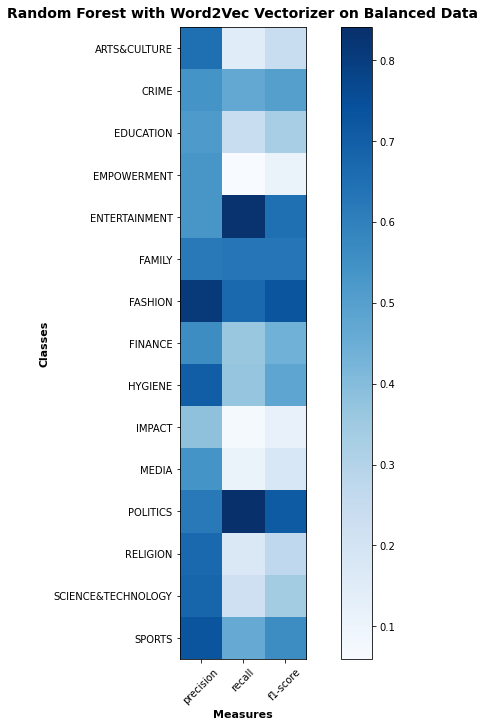

In [336]:
w2v_rf_cw_ClassificationReport = """             precision    recall  f1-score   support

        ARTS&CULTURE       0.65      0.15      0.24       992
               CRIME       0.54      0.47      0.50       856
           EDUCATION       0.52      0.24      0.33       550
         EMPOWERMENT       0.53      0.06      0.11      1213
       ENTERTAINMENT       0.53      0.83      0.65      9870
              FAMILY       0.62      0.63      0.63      4984
             FASHION       0.81      0.67      0.73      2982
             FINANCE       0.56      0.36      0.44      1951
             HYGIENE       0.70      0.37      0.48      2050
              IMPACT       0.38      0.07      0.12       865
               MEDIA       0.54      0.11      0.18      1717
            POLITICS       0.62      0.84      0.71      8061
            RELIGION       0.67      0.17      0.27       601
  SCIENCE&TECHNOLOGY       0.68      0.22      0.34      1073
              SPORTS       0.73      0.46      0.56      1180
              VOICES       0.56      0.29      0.39      2981
            WELLNESS       0.62      0.78      0.69      6175
          WORLD NEWS       0.67      0.53      0.59      2113"""


w2v_rf_cw_crplot = plot_classification_report(w2v_rf_cw_ClassificationReport, title="Random Forest with Word2Vec Vectorizer on Balanced Data")
w2v_rf_cw_crplot


## Random Forest Performance

In [337]:
rf_balanced_accuracies = {'Count Vec': cvec_rf_cw_acc, 'Tf-Idf Vec': tfidf_rf_cw_acc, 'Word2Vec': w2v_rf_cw_acc}
rf_imbalanced_accuracies = {'Count Vec': cvec_rf_acc, 'Tf-Idf Vec': tfidf_rf_acc, 'Word2Vec': w2v_rf_acc}


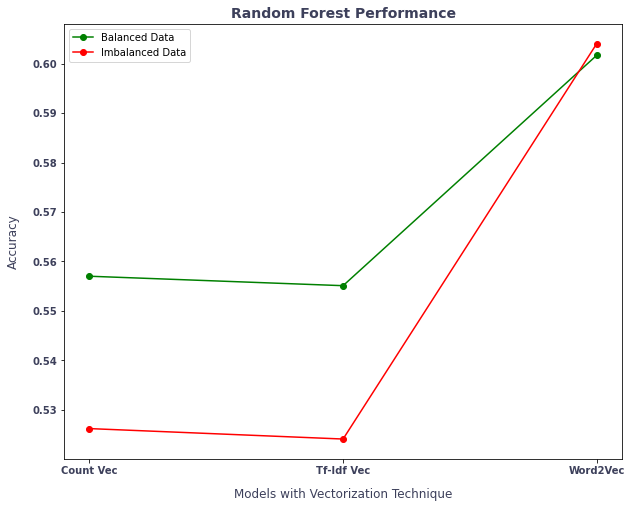

In [338]:
x = list(rf_balanced_accuracies.keys())
y_bal = list(rf_balanced_accuracies.values())
y_imbal = list(rf_imbalanced_accuracies.values())
plt.figure(figsize=(10,8))
plt.plot(x, y_bal, label= "Balanced Data", color='green', marker='o')
plt.plot(x, y_imbal, label= "Imbalanced Data", color='red', marker='o')
plt.title('Random Forest Performance', fontweight="bold", fontsize=14, color="#3D405B")
plt.xlabel('Models with Vectorization Technique', fontsize = 12, labelpad=12, color="#3D405B")
plt.ylabel('Accuracy', fontsize=12, labelpad=12, color="#3D405B")
plt.xticks(fontweight="bold", fontsize=10, color="#3D405B")
plt.yticks(fontweight="bold", fontsize=10, color="#3D405B")
plt.legend()
plt.show()

------

## Models Performance

In [372]:
columns = ['Model', 'CountV Accuracy', 'Tf-idf Accuracy', 'Word2Vec Accuracy']
model_names = ['LinearSVC', 'Logistic\nRegression', 'Random\nForest']


### Models Performance on Balanced Data

In [373]:
cvec_accs = [round(list(lsvc_balanced_accuracies.values())[0],2), round(list(lr_balanced_accuracies.values())[0],2), round(list(rf_balanced_accuracies.values())[0],2)]
tfidf_accs = [round(list(lsvc_balanced_accuracies.values())[1],2), round(list(lr_balanced_accuracies.values())[1],2), round(list(rf_balanced_accuracies.values())[1],2)]
w2v_accs = [round(list(lsvc_balanced_accuracies.values())[2],2), round(list(lr_balanced_accuracies.values())[2],2), round(list(rf_balanced_accuracies.values())[2],2)]


models_bal_df = pd.DataFrame(np.column_stack([model_names, cvec_accs, tfidf_accs, w2v_accs]), 
                               columns=columns)
models_bal_df

,Model,CountV Accuracy,Tf-idf Accuracy,Word2Vec Accuracy
0,LinearSVC,0.63,0.67,0.57
1,Logistic\nRegression,0.63,0.64,0.53
2,Random\nForest,0.56,0.56,0.6


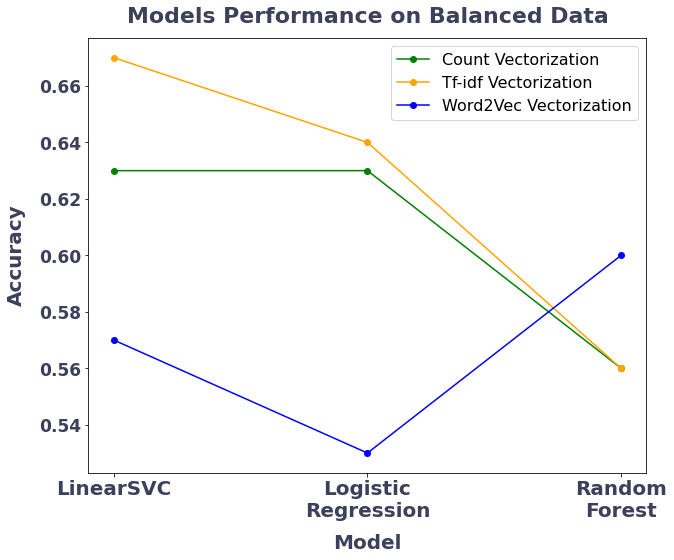

In [376]:
x = model_names
y_cvec = cvec_accs
y_tfidf = tfidf_accs
y_w2v = w2v_accs
plt.figure(figsize=(10,8))
plt.plot(x, y_cvec, label= "Count Vectorization", color='green', marker='o')
plt.plot(x, y_tfidf, label= "Tf-idf Vectorization", color='orange', marker='o')
plt.plot(x, y_w2v, label= "Word2Vec Vectorization", color='blue', marker='o')
plt.title('Models Performance on Balanced Data', fontweight="bold", fontsize=22, color="#3D405B", pad=15)
plt.xlabel('Model', fontsize = 20, labelpad=13, color="#3D405B", fontweight="bold")
plt.ylabel('Accuracy', fontsize=20, labelpad=13, color="#3D405B", fontweight="bold")
plt.xticks(fontweight="bold", fontsize=20, color="#3D405B")
plt.yticks(fontweight="bold", fontsize=17, color="#3D405B")
plt.legend(fontsize=16, loc='upper right')
plt.show()

### Models Performance on Imbalanced Data

In [345]:
cvec_im_accs = [round(list(lsvc_imbalanced_accuracies.values())[0],2), round(list(lr_imbalanced_accuracies.values())[0],2), round(list(rf_imbalanced_accuracies.values())[0],2)]
tfidf_im_accs = [round(list(lsvc_imbalanced_accuracies.values())[1],2), round(list(lr_imbalanced_accuracies.values())[1],2), round(list(rf_imbalanced_accuracies.values())[1],2)]
w2v_im_accs = [round(list(lsvc_imbalanced_accuracies.values())[2],2), round(list(lr_imbalanced_accuracies.values())[2],2), round(list(rf_imbalanced_accuracies.values())[2],2)]


models_imbal_df = pd.DataFrame(np.column_stack([model_names, cvec_im_accs, tfidf_im_accs, w2v_im_accs]), 
                               columns=columns)
models_imbal_df

,Model,CountV Accuracy,Tf-idf Accuracy,Word2Vec Accuracy
0,LinearSVC,0.64,0.69,0.59
1,Logistic Regression,0.67,0.67,0.61
2,Random Forest,0.53,0.52,0.6


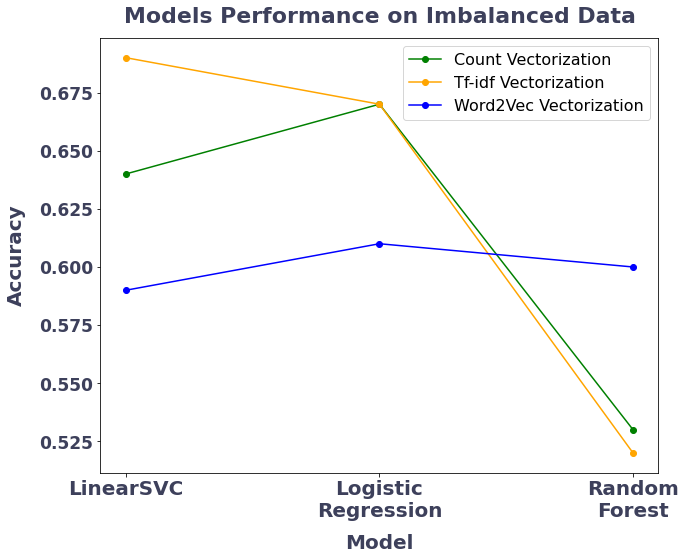

In [377]:
x = model_names
y_cvec = cvec_im_accs
y_tfidf = tfidf_im_accs
y_w2v = w2v_im_accs
plt.figure(figsize=(10,8))
plt.plot(x, y_cvec, label= "Count Vectorization", color='green', marker='o')
plt.plot(x, y_tfidf, label= "Tf-idf Vectorization", color='orange', marker='o')
plt.plot(x, y_w2v, label= "Word2Vec Vectorization", color='blue', marker='o')
plt.title('Models Performance on Imbalanced Data', fontweight="bold", fontsize=22, color="#3D405B", pad=15)
plt.xlabel('Model', fontsize = 20, labelpad=13, color="#3D405B", fontweight="bold")
plt.ylabel('Accuracy', fontsize=20, labelpad=13, color="#3D405B", fontweight="bold")
plt.xticks(fontweight="bold", fontsize=20, color="#3D405B")
plt.yticks(fontweight="bold", fontsize=17, color="#3D405B")
plt.legend(fontsize=16, loc='upper right')
plt.show()